## Recurrent Neural Networks

### Sequence Modelling

In [1]:
import tensorflow as tf
from utils import util_functions as utils

2024-12-26 14:30:34.210221: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-26 14:30:34.210244: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-26 14:30:34.210248: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-26 14:30:34.210275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-26 14:30:34.210289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
class Data(utils.DataModule):
  def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
    self.save_hyperparameters()
    self.time = tf.range(start=1, limit=T + 1, dtype=tf.float32)
    self.x = tf.sin(0.01 * self.time) + tf.random.normal([T]) * 0.2

  def get_dataloader(self, train):
    features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
    self.features = tf.stack(features, axis=1)
    self.labels = tf.reshape(self.x[self.tau:], (-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(tensors=(self.features, self.labels), train=train, indices=i)

with tf.device('CPU: 0'):
  data = Data()

In [4]:
class LinearRegression(utils.Module):
  """Linear Regression implemented with high level API"""
  def __init__(self, lr):
    super().__init__()
    self.save_hyperparameters()
    initializer = tf.random_normal_initializer(stddev=0.01)
    self.net = tf.keras.layers.Dense(units=1, kernel_initializer=initializer)

  def forward(self, X):
    return self.net(X)
  
  def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

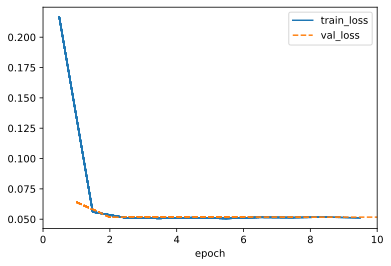

In [5]:
with tf.device('CPU: 0'):
  model = LinearRegression(lr=0.01)
  Trainer = utils.Trainer(max_epochs=10)
  Trainer.fit(model=model, data=data)

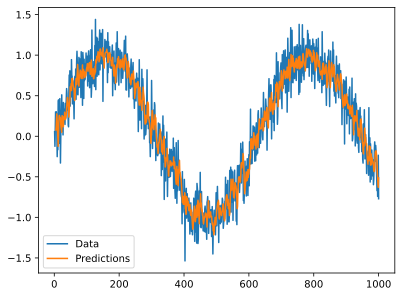

In [6]:
onestep_preds = model(data.features).numpy()

import matplotlib.pyplot as plt
plt.plot(data.time, data.x, label='Data')
plt.plot(data.time[data.tau:], onestep_preds, label='Predictions')
plt.legend()
plt.show()

In [7]:
with tf.device('CPU: 0'):
  multistep_preds = tf.Variable(tf.zeros(data.x.shape))
  multistep_preds[:].assign(data.x)
  for i in range(data.num_train + data.tau, data.T):
    features = tf.reshape(tensor=multistep_preds[i - data.tau: i], shape=(1, -1))
    prediction = model(features)
    multistep_preds[i].assign(tf.reshape(prediction, (1, -1)))

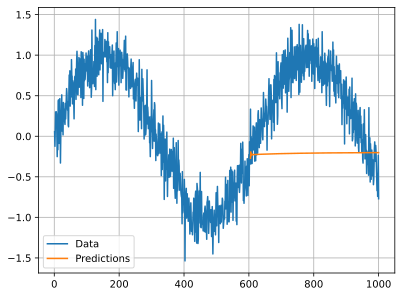

In [8]:
import matplotlib.pyplot as plt
plt.plot(data.time, data.x, label='Data')
plt.plot(data.time[data.num_train + data.tau:], multistep_preds[data.num_train + data.tau:], label='Predictions')
plt.legend()
plt.grid()
plt.show()

### Preparing Text Datasets

Typical preprocessing pipelines execute the following steps:
1. Load text as strings into memory
2. Split the strings into tokens (e.g., words or characters)
3. Build a vocabulary dictionary to associate each vocabulary element with a numerical index
4. Convert the text into sequences of numerical indices

In [9]:
import collections
import random
import re
import tensorflow as tf
from d2l import tensorflow as d2l

In [10]:
class Vocab:
  """Pass Raw Dataset splited on tokens or list(tokens) to vocab"""
  def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
    if tokens and isinstance(tokens[0], list):
      tokens = [token for line in tokens for token in line]
    counter = collections.Counter(tokens)
    self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    self.idx_to_token = list(sorted(['<unk>'] + reserved_tokens + \
                               [token for token, freq in self.token_freqs if freq >= min_freq]))
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens): ## Overload of [] operator
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]
  
  def to_tokens(self, indices):
    if hasattr(indices, '__len__') and len(indices) > 1:
      return [self.idx_to_token[idx] for idx in indices]
    return self.idx_to_token[indices]

  @property
  def unk(self):
    return self.token_to_idx['<unk>']  

In [11]:
class TimeMachine(d2l.DataModule):
  """Downloads the text. Tokenize the text. Pass it to vocab and get corpus and vocab as output. Generate X and y"""
  def _download(self):
    fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
      '090b5e7e70c295757f55df93cb0a180b9691891a')
    with open(fname) as f:
      return f.read()
    
  def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()
  
  def _tokenize(self, text):
    return list(text)
  
  def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None:
      vocab = Vocab(tokens=tokens)
      corpus = [vocab[token] for token in tokens]
      return corpus, vocab
    
  def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super().__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = tf.constant([corpus[i : i+num_steps+1] for i in range(len(corpus) - num_steps)])
    self.X, self.Y = array[:, :-1], array[:, 1:]

  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(tensors=(self.X, self.Y), train=train, indices=i)
  
data = TimeMachine(batch_size=2, num_steps=10)

In [12]:
for X, y in data.train_dataloader():
  print(X)
  print(y)
  break

tf.Tensor(
[[21 24  6  6 15  0 21 10 14  6]
 [21  9 19  6  6  0  2 15  5  0]], shape=(2, 10), dtype=int32)
tf.Tensor(
[[24  6  6 15  0 21 10 14  6  0]
 [ 9 19  6  6  0  2 15  5  0 20]], shape=(2, 10), dtype=int32)


In [13]:
data.vocab.to_tokens(list(X[0].numpy()))

['t', 'w', 'e', 'e', 'n', ' ', 't', 'i', 'm', 'e']

In [14]:
data.vocab.to_tokens(list(y[0].numpy()))

['w', 'e', 'e', 'n', ' ', 't', 'i', 'm', 'e', ' ']

In [15]:
tokens = data._tokenize(data._preprocess(text=data._download()))
vocab = Vocab(tokens=tokens)

In [16]:
indices = vocab[tokens[:10]]
print(indices)
print(vocab.to_tokens(indices))

[21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


To preprocess text, we usually 
(i) split text into tokens; 
(ii) build a vocabulary to map token strings to numerical indices; and 
(iii) construct corpus: convert text data into token indices for models to manipulate.
(iv) create features and target array

Imp: Perplexity Loss: measures quality of language model

### Language Models

Perplexity Loss

### RNN Implementation from Scratch

In [17]:
%matplotlib inline
import math
import tensorflow as tf
from utils import util_functions as utils

In [18]:
class RNN(utils.Module):
  ## Accepts One Hot Encoded Inputs
  ## Gives out list of states and last state
  def __init__(self, num_inputs, num_hiddens, sigma=0.1):
    super().__init__()
    self.save_hyperparameters()
    self.rnn = tf.keras.layers.SimpleRNN(units=num_hiddens, return_sequences=True, return_state=True, time_major=True)

  def forward(self, X, state=None):
    """
    X: (batch_size, num_steps, num_inputs)
    state: (num_batches, num_hiddens)
    """
    outputs, state = self.rnn(X, state)
    
    ## Outputs: shape (batch_size, num_steps, num_hiddens)
    ## State: shape (batch_size, num_hiddens)
    return outputs, state

In [24]:
class RNNScratch(utils.Module):
  ## Accepts One Hot Encoded Inputs
  ## Gives out list of states and last state
  def __init__(self, num_inputs, num_hiddens, sigma=0.1):
    super().__init__()
    self.save_hyperparameters()
    self.W_xh = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=sigma))
    self.W_hh = tf.Variable(tf.random.normal(shape=(num_hiddens, num_hiddens), mean=0, stddev=sigma))
    self.b_h = tf.Variable(tf.zeros(shape=(num_hiddens)))

  def forward(self, X, state=None):
    """
    X: (batch_size, num_steps, num_inputs)
    state: (num_batches, num_hiddens)
    """
    num_batches, num_steps, num_inputs = X.shape
    if state is None:
      state = tf.zeros(shape=(num_batches, self.num_hiddens))
    else:
      state,  = state
      state = tf.reshape(state, shape=(-1, self.num_hiddens))
    outputs = []
    X = tf.transpose(X, perm=[1, 0, 2]) 
    ## (num_steps, batch_size, num_inputs)
    for x in X:
      ## X has shape (batch_size, num_inputs)
      state = tf.tanh(tf.matmul(x, self.W_xh) + tf.matmul(state, self.W_hh) + self.b_h)
      outputs.append(state)
    
    ## Outputs: shape (batch_size, num_steps, num_hiddens)
    ## State: shape (batch_size, num_hiddens)
    return tf.stack(outputs, axis=1), state

In [29]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNN(num_inputs=num_inputs, num_hiddens=num_hiddens, sigma=0.1)
X = tf.ones(shape=(batch_size, num_steps, num_inputs))
output, state = rnn(X)

In [30]:
output.shape

TensorShape([2, 100, 32])

In [31]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs=num_inputs, num_hiddens=num_hiddens, sigma=0.1)
X = tf.ones(shape=(batch_size, num_steps, num_inputs))
output, state = rnn(X)

In [32]:
output.shape

TensorShape([2, 100, 32])

In [33]:
class RNNLMScratch(utils.Classifier):
  """Accepts RNN and Vocab as Input
     1. Encodes Input to One Hot
     2. Forward Method: Encodes input to one hot, Pass it on to rnn get the states, pass it to output layer to get logits
     3. Compute Loss
     4. Define Predict Method
  """
  def __init__(self, rnn, vocab_size, lr=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.init_params()

  def init_params(self):
    self.W_hq = tf.Variable(initial_value=tf.random.normal(shape=(self.rnn.num_hiddens, self.vocab_size), mean=0, stddev=self.rnn.sigma))
    self.b_q = tf.Variable(tf.zeros(self.vocab_size))

  def one_hot(self, X):
    """X has shape: (batch_size, num_steps)
       Output: (batch_size, num_steps, vocab_size)
    """
    X_t = X
    return tf.one_hot(indices=X_t, depth=self.vocab_size, axis=-1)
  
  def output_layer(self, rnn_outputs):
    ## rnn_outputs: shape (batch_size, num_steps, num_hiddens)
    
    outputs = tf.matmul(rnn_outputs, self.W_hq) + self.b_q
    ## Shape (batch_size, num_steps, vocab_size)) 

    return outputs
  
  def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(X=embs, state=state)
    return self.output_layer(rnn_outputs=rnn_outputs)
    
  def training_step(self, batch):
    X, y = batch
    y_pred = self(X)
    l = self.loss(y=y, y_hat=y_pred)
    self.plot('ppl', tf.exp(l), train=True)
    return l

  def validation_step(self, batch):
    X, y = batch
    y_pred = self(X)
    l = self.loss(y=y, y_hat=y_pred)
    self.plot('ppl', tf.exp(l), train=False)

  def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
      X = tf.constant([[outputs[-1]]]) ## (num_batches, num_inputs)
      embs = self.one_hot(X)
      rnn_outputs, state = self.rnn(X=embs, state=state)
      if i < len(prefix) - 1:
        outputs.append(vocab[prefix[i+1]])
      else:
        Y = self.output_layer(rnn_outputs=rnn_outputs)
        output = int(tf.reshape(tf.argmax(Y, axis=2), shape=1))
        outputs.append(output)
    
    return ''.join(vocab.idx_to_token[i] for i in outputs)

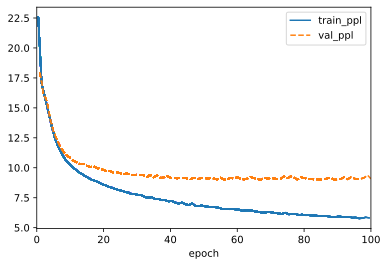

In [34]:
with tf.device('CPU: 0'):
  data = TimeMachine(batch_size=1024, num_steps=32)
  rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
  model = RNNLMScratch(rnn=rnn, vocab_size=len(data.vocab), lr=1)
  Trainer = utils.Trainer(max_epochs=100, gradient_clip_val=1)
  Trainer.fit(model, data)

In [35]:
model.predict('it has', 20, data.vocab)

'it has the the the the the'